In [67]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# import modules
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Lasso

import warnings
warnings.filterwarnings('ignore')

In [68]:
df = pd.read_csv('../Data/potholes_updated.csv')

In [69]:
df.head()

,Unnamed: 0.1,Unnamed: 0,the_geom,DefNum,InitBy,OFT,OnFaceName,OnPrimName,FrmPrimNam,ToPrimName,...,street_name,neighbour_hood,days_to_fix,month,year,DATE,PRCP,SNOW,TMIN,TMAX
0,0,11,MULTILINESTRING ((-73.92993757815543 40.597146...,DB2010002001,CSC,343910312370314730,GERRITSEN AV,GERRITSEN AVENUE,ALLEN AVENUE,AVENUE W,...,Avenue W,Gerritsen Beach,3.0,January,2010-01-02,2010-01-02,0.02,0.2,17.0,34.0
1,1,12,MULTILINESTRING ((-73.9393340798436 40.6227256...,DB2010002004,CSC,336480314180354050,E 37 ST,EAST 37 STREET,AVENUE L,KINGS HIGHWAY,...,East 37th Street,NaN,3.0,January,2010-01-02,2010-01-02,0.02,0.2,17.0,34.0
2,2,97384,MULTILINESTRING ((-73.95918180056893 40.771696...,DM2010002002,CSC,110210118490118510,3 AV,3 AVENUE,EAST 75 STREET,EAST 76 STREET,...,3rd Avenue,Manhattan Community Board 8,2.0,January,2010-01-02,2010-01-02,0.02,0.2,17.0,34.0
3,3,97390,MULTILINESTRING ((-73.95918180056893 40.771696...,DM2010003021,YRD,110210118490118510,3 AV,3 AVENUE,EAST 75 STREET,EAST 76 STREET,...,3rd Avenue,Manhattan Community Board 8,1.0,January,2010-01-02,2010-01-02,0.02,0.2,17.0,34.0
4,4,97391,MULTILINESTRING ((-73.95172338255492 40.773656...,DM2010003023,YRD,110010118610118630,1 AV,1 AVENUE,EAST 81 STREET,EAST 82 STREET,...,1st Avenue,Yorkville,1.0,January,2010-01-02,2010-01-02,0.02,0.2,17.0,34.0


#### Check Correlation of Features

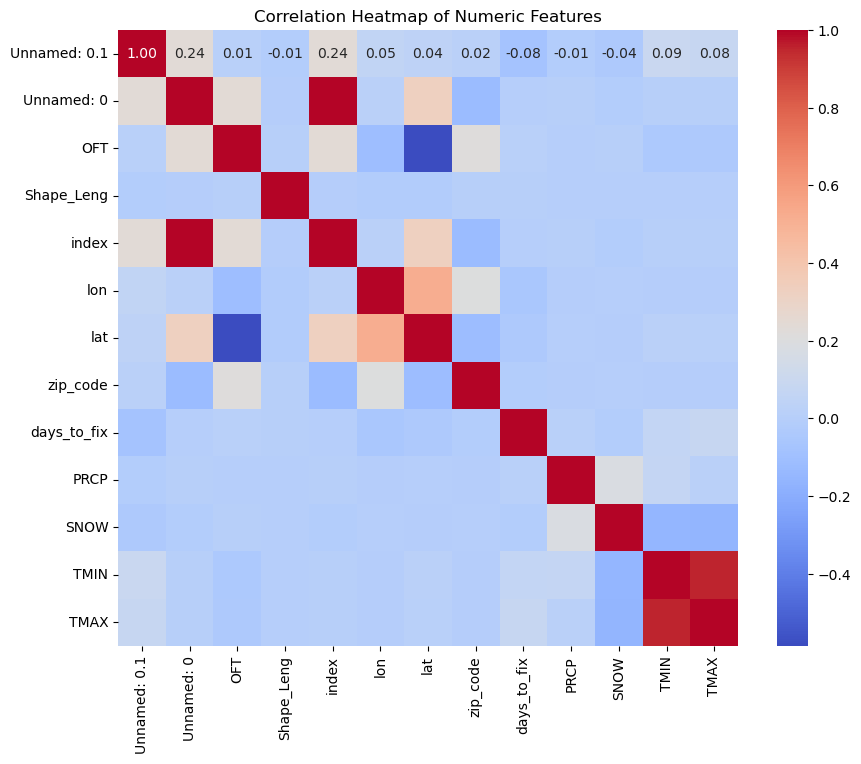

In [70]:
numeric_df = df.select_dtypes(include='number')

# Calculate correlation matrix
corr_matrix = numeric_df.corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numeric Features')
plt.show()

Overall there is a trend of negative and zero co-relations between features which is not providing a useful insight to gather the imortance of features for the occurence of potholes. So far latitudes and longitudes have a good correlation with zip code.
Feature name "Shape_Leng" is not actually helping at all. So I am going to drop this feature.

In [71]:
sel  = (df['days_to_fix'] >= 0)  &  (df['days_to_fix'] <= 100)
zip_counts = df.groupby('zip_code')['zip_code'].count()
zip_count_sel = zip_counts > 100
zips = list((zip_counts[zip_count_sel]).index)
zip_sel = df['zip_code'].isin(zips)
total_sel = sel & zip_sel
df = df[total_sel]
df.shape

(339642, 30)

### Creating Dummmy variables for Zip Codes, Boro, Source

In [72]:
one_hot_encoded_zip = pd.get_dummies(df['zip_code'], prefix='Zip')
one_hot_encoded_boro = pd.get_dummies(df['Boro'], prefix='Boro')
one_hot_encoded_source = pd.get_dummies(df['Source'], prefix='Source')
one_hot_encoded_init = pd.get_dummies(df['InitBy'], prefix='Init')
one_hot_encoded_month = pd.get_dummies(df['month'], prefix='month')

df = pd.concat([df, one_hot_encoded_boro, one_hot_encoded_init, one_hot_encoded_month, one_hot_encoded_source, one_hot_encoded_zip], axis=1)

In [73]:
df.head()

,Unnamed: 0.1,Unnamed: 0,the_geom,DefNum,InitBy,OFT,OnFaceName,OnPrimName,FrmPrimNam,ToPrimName,...,Zip_11432,Zip_11433,Zip_11434,Zip_11435,Zip_11436,Zip_11691,Zip_11692,Zip_11693,Zip_11694,Zip_66801
0,0,11,MULTILINESTRING ((-73.92993757815543 40.597146...,DB2010002001,CSC,343910312370314730,GERRITSEN AV,GERRITSEN AVENUE,ALLEN AVENUE,AVENUE W,...,False,False,False,False,False,False,False,False,False,False
1,1,12,MULTILINESTRING ((-73.9393340798436 40.6227256...,DB2010002004,CSC,336480314180354050,E 37 ST,EAST 37 STREET,AVENUE L,KINGS HIGHWAY,...,False,False,False,False,False,False,False,False,False,False
2,2,97384,MULTILINESTRING ((-73.95918180056893 40.771696...,DM2010002002,CSC,110210118490118510,3 AV,3 AVENUE,EAST 75 STREET,EAST 76 STREET,...,False,False,False,False,False,False,False,False,False,False
3,3,97390,MULTILINESTRING ((-73.95918180056893 40.771696...,DM2010003021,YRD,110210118490118510,3 AV,3 AVENUE,EAST 75 STREET,EAST 76 STREET,...,False,False,False,False,False,False,False,False,False,False
4,4,97391,MULTILINESTRING ((-73.95172338255492 40.773656...,DM2010003023,YRD,110010118610118630,1 AV,1 AVENUE,EAST 81 STREET,EAST 82 STREET,...,False,False,False,False,False,False,False,False,False,False


In [74]:
sel  = (df['days_to_fix'] >= 0)  &  (df['days_to_fix'] <= 400)
zip_counts = df.groupby('zip_code')['zip_code'].count()
zip_count_sel = zip_counts > 50
zips = list((zip_counts[zip_count_sel]).index)
zip_sel = df['zip_code'].isin(zips)
total_sel = sel & zip_sel
df = df[total_sel]
df.shape

(339642, 270)

In [75]:
# df.to_csv('numeric_df.csv', index=False)

<Axes: >

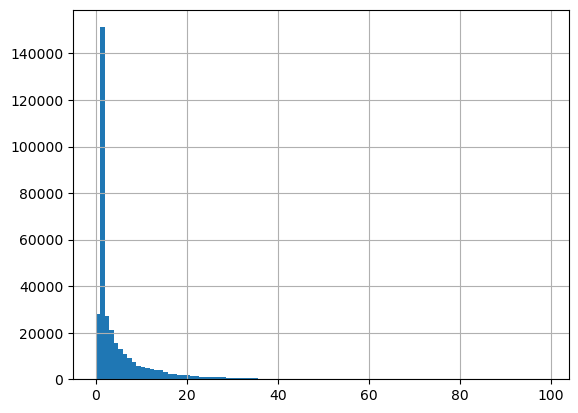

In [76]:
df['days_to_fix'].hist(bins=100)

In [77]:
# df.head()
# first_row = df.iloc[0]

# first_row.drop('days_to_fix')

Preparing the data for analysis and modelling. Dropping the columns which have already been converted to dummies and labels. Also we have feature engineered the locations as zip codes and street names so I am dropping all columns related to locations as they have large nummber of nulls and I can't impute or replace those. Dropping RptDate and RptClosed as I have feature engineered the month column for seasonality.

In [78]:
df = df.drop(columns=['Unnamed: 0.1', 'Unnamed: 0', 'the_geom', 'DefNum', 'OFT', 'OnFaceName', 'FrmPrimNam', 'ToPrimName' , 'OnPrimName','street_name', 'index', 'RptDate', 'RptClosed' , 'neighbour_hood','building_number','DATE','year'])

In [79]:
df = df.drop(columns=['Boro', 'Source', 'month', 'InitBy'])

In [80]:
df.head()

,Shape_Leng,lon,lat,zip_code,days_to_fix,PRCP,SNOW,TMIN,TMAX,Boro_B,...,Zip_11432,Zip_11433,Zip_11434,Zip_11435,Zip_11436,Zip_11691,Zip_11692,Zip_11693,Zip_11694,Zip_66801
0,82.707368,-73.929938,40.597147,11229,3.0,0.02,0.2,17.0,34.0,True,...,False,False,False,False,False,False,False,False,False,False
1,426.877885,-73.939334,40.622726,11210,3.0,0.02,0.2,17.0,34.0,True,...,False,False,False,False,False,False,False,False,False,False
2,264.702760,-73.959182,40.771697,10021,2.0,0.02,0.2,17.0,34.0,False,...,False,False,False,False,False,False,False,False,False,False
3,264.702760,-73.959182,40.771697,10021,1.0,0.02,0.2,17.0,34.0,False,...,False,False,False,False,False,False,False,False,False,False
4,264.464803,-73.951723,40.773657,10028,1.0,0.02,0.2,17.0,34.0,False,...,False,False,False,False,False,False,False,False,False,False


In [81]:
X = df.drop(['days_to_fix'], axis=1)
y = df['days_to_fix']
X.shape

(339642, 248)

In [82]:
df.head()

,Shape_Leng,lon,lat,zip_code,days_to_fix,PRCP,SNOW,TMIN,TMAX,Boro_B,...,Zip_11432,Zip_11433,Zip_11434,Zip_11435,Zip_11436,Zip_11691,Zip_11692,Zip_11693,Zip_11694,Zip_66801
0,82.707368,-73.929938,40.597147,11229,3.0,0.02,0.2,17.0,34.0,True,...,False,False,False,False,False,False,False,False,False,False
1,426.877885,-73.939334,40.622726,11210,3.0,0.02,0.2,17.0,34.0,True,...,False,False,False,False,False,False,False,False,False,False
2,264.702760,-73.959182,40.771697,10021,2.0,0.02,0.2,17.0,34.0,False,...,False,False,False,False,False,False,False,False,False,False
3,264.702760,-73.959182,40.771697,10021,1.0,0.02,0.2,17.0,34.0,False,...,False,False,False,False,False,False,False,False,False,False
4,264.464803,-73.951723,40.773657,10028,1.0,0.02,0.2,17.0,34.0,False,...,False,False,False,False,False,False,False,False,False,False


Explained Variance Ratio: [1.79514330e-01 1.55912341e-01 1.38970876e-01 9.69614758e-02
 9.00021566e-02 7.89433463e-02 7.68276199e-02 6.58242924e-02
 5.99090340e-02 4.44976072e-02 9.24568795e-03 3.39122316e-03
 9.23670077e-09]


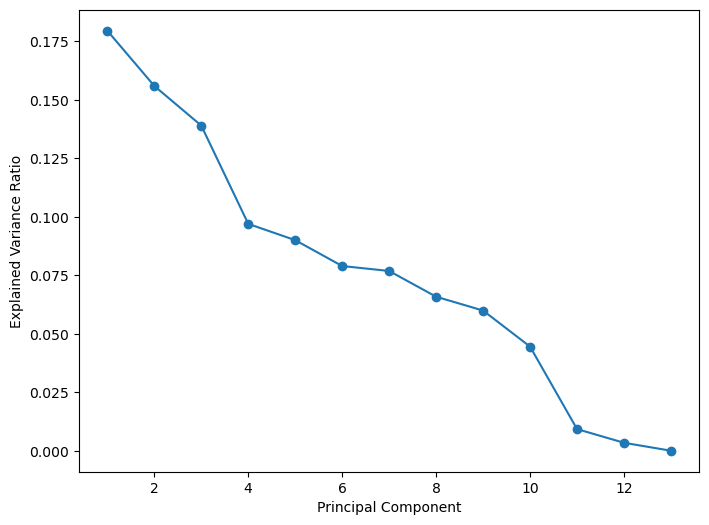

In [83]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(numeric_df)

pca = PCA()
principal_components = pca.fit_transform(scaled_features)

explained_variance_ratio = pca.explained_variance_ratio_
print("Explained Variance Ratio:", explained_variance_ratio)

# Step 4: Scree Plot
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='-')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.show()

In [84]:
# Split the data into training and testing sets
from sklearn.metrics import r2_score, mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit the Random Forest Regressor with max depth of 10
rf_regressor = RandomForestRegressor(max_depth=10, random_state=42)
rf_regressor.fit(X_train_scaled, y_train)

# Calculate the test R-squared score
y_pred = rf_regressor.predict(X_test_scaled)
test_r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print("Test R-squared (R2) score:", test_r2)
print("Mean Squared Error (MSE):", mse)

# Get feature importances
feature_importances = rf_regressor.feature_importances_

# Get names of top 10 features
top10_indices = np.argsort(feature_importances)[::-1][:10]
top10_feature_names = X.columns[top10_indices]

# Plot feature importances of top 10 features
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances[top10_indices], y=top10_feature_names, orient='h')
plt.xlabel('Feature Importance')
plt.ylabel('Labeled Features')
plt.title('Top 10 Features Importance')
plt.show()

KeyboardInterrupt: 

In [ ]:
import joblib

joblib.dump(rf_regressor, 'random_forest_model.joblib')

df.to_csv('num_df.csv', index=False)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score, mean_squared_error

# Assuming you have your data loaded into X (features) and y (target variable)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline with StandardScaler and Lasso regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', Lasso())
])

# Define parameter grid for GridSearchCV
param_grid = {
    'lasso__alpha': [0.0001, 0.000001, 0.001, 0.01]  # Example alpha values to search over
}

# Grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5)  # 5-fold cross-validation
grid_search.fit(X_train, y_train)

# Get best model
best_model = grid_search.best_estimator_

# Evaluate the model
y_pred = best_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

# Get coefficients and corresponding feature names from the best model
coefficients = best_model.named_steps['lasso'].coef_
feature_names = X.columns

# Create a DataFrame to store coefficients and feature names
coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Sort coefficients by absolute value
coefficients_df['Abs_Coefficient'] = np.abs(coefficients_df['Coefficient'])
coefficients_df = coefficients_df.sort_values(by='Abs_Coefficient', ascending=False)

# Select top 10 coefficients
top_10_coefficients = coefficients_df.head(10)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(top_10_coefficients['Feature'], top_10_coefficients['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Top 10 Features for Lasso Regression')
plt.gca().invert_yaxis()  # Invert y-axis to have the largest coefficients on top
plt.show()

# Print evaluation metrics
print("R-squared (R2) Score:", r2)
print("Mean Squared Error (MSE):", mse)

In [ ]:
print(best_model)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit the Lasso regression model
lasso = Lasso(alpha=0.001)
lasso.fit(X_train_scaled, y_train)

# Evaluate the model
train_score = lasso.score(X_train_scaled, y_train)
test_score = lasso.score(X_test_scaled, y_test)

print(f"Training R^2 score: {train_score}")
print(f"Test R^2 score: {test_score}")

In [ ]:
X.shape

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the Random Forest Regression model
# You can adjust the parameters as needed
rf_regressor = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_regressor.fit(X_train_scaled, y_train)

# Make predictions
y_pred = rf_regressor.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("R-squared (R2) score:", r2)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define preprocessing steps (standard scaling)
scaler = StandardScaler()

# Define Random Forest Regressor model with hyperparameters to tune
rf_regressor = RandomForestRegressor(random_state=42)

# Define pipeline
pipeline = Pipeline([
    ('scaler', scaler),
    ('rf', rf_regressor)
])

# Define hyperparameters grid for GridSearchCV
param_grid = {
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': [8, 9, 10,11, 13],
    'rf__min_samples_split': [2, 5, 8],
    'rf__min_samples_leaf': [1, 2, 4]
}

# Perform GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions
y_pred = best_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Best Model Parameters:", grid_search.best_params_)
print("Mean Squared Error:", mse)
print("R-squared (R2) score:", r2)

In [ ]:
from joblib import dump, load
dump(rf_regressor, 'rf_regressor.joblib')

#### PCA analysis